In [59]:
pip install PySastrawi

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import csv
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model, Sequential, load_model
from keras.layers import (Dense, Input, LSTM,Conv1D, Embedding, Dropout, Activation, GRU, Flatten,
                          Bidirectional, GlobalMaxPool1D, Convolution1D, MaxPooling1D, BatchNormalization)

from keras import losses
from keras.optimizers import Adam, SGD
from keras.metrics import Precision, Recall
from keras.callbacks import LearningRateScheduler, History ,EarlyStopping
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, losses, datasets

import pickle
import requests



In [61]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rizky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;color:white">Analysis Sentiment</p>

## <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px; color:white;">Table of Content</p>

* [1. Integration Data 💎](#1)
* [2. EDA 📊](#2)
    * [2.1 WordCloud 🛠](#2.1)
* [3. Data Preprocessing ⚙️](#3)
    * [3.1 Cleaning 🛠](#3.1)
    * [3.2 Processing 🛠](#3.2)
* [4. Extration Feature 📊](#4)
    * [4.1 BoW](#4.1)
    * [4.2 TfIdf](#4.2)
    * [4.3 Word Embeddings: GloVe](#4.3)
* [5. Tokenize & Padding](#5)
* [6. Modeling](#6)
    * [6.1 BoW LSTM](#6.1)
    * [6.2 TF-IDF LSTM](#6.2)
    * [6.3 TF-IDF LSTM](#6.3)
* [7.Metric Evaluation](#7)
    * [7.1 Confusion Metric](#7.1)
    * [7.1 Confusion Metric](#7.1)


<a id='1'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">1. Integration Data 💎</p>

In [62]:
df1 = "https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv"
df1 = pd.read_csv(df1, lineterminator="\n")
df1 = df1[['tweet','label']].rename(columns={'tweet':'Tweet'})
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",anger
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",anger
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,happy
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",anger
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",happy
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",love
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,fear
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",anger
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,happy


In [63]:
# Mendefinisikan mapping dari emosi ke sentimen
emotion_to_sentiment = {
    'happy': 'positive',
    'love': 'positive',
    'anger': 'negative',
    'sadness': 'negative',
    'fear': 'negative'
}
# Mengubah label emosi menjadi label sentimen
df1['label'] = df1['label'].map(emotion_to_sentiment)
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",negative
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",positive
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",positive
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,negative
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",negative
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,positive


In [64]:
df2 = pd.read_csv("https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/INA_TweetsPPKM_Labeled_Pure.csv", sep="\t")
df2.drop(columns=["Date", "User"], inplace=True)
df2.rename(columns={"sentiment": "label"}, inplace=True)
df2

,Tweet,label
0,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,Kementerian Agama menerbitkan Surat Edaran Nom...,1
...,...,...
23639,noelle loses a bet to akarsha and it somehow e...,1
23640,they call her... weekeeshee...\n#butterflysoup...,1
23641,"put out what you wanna see more of, amirite ga...",1
23642,"i don't need anybody, i'm fine here on my own\...",1


In [65]:
# Menghitung jumlah baris untuk setiap label
label_counts = df2['label'].value_counts()

# Mengambil 70% dari baris dengan label 'neutral'
neutral_rows = df2[df2['label'] == 1]
reduced_neutral_rows = neutral_rows.sample(n=int(len(neutral_rows)*0.3), random_state=1)

# Mengambil semua baris dengan label selain 'neutral'
other_rows = df2[df2['label'] != 1]

# Menggabungkan baris yang telah direduksi dengan baris lainnya
df2 = pd.concat([other_rows, reduced_neutral_rows])

df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,2
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,0
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,0
47,Thank You teman-teman dari #saganheritagehotel...,0
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,0
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,1
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,1
12817,Jadi di perpanjang atau stop sampai hari ini s...,1
4932,Polres Kepulauan Seribu Terus bagikan masker d...,1


In [66]:
number_to_sentiment = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}
df2['label'] = df2['label'].map(number_to_sentiment)
df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,negative
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,positive
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,positive
47,Thank You teman-teman dari #saganheritagehotel...,positive
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,positive
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,neutral
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,neutral
12817,Jadi di perpanjang atau stop sampai hari ini s...,neutral
4932,Polres Kepulauan Seribu Terus bagikan masker d...,neutral


In [67]:
df3 = pd.read_csv(r"https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/sentimen%20label.csv")
df3.rename(columns={"polarity": "label",'tweet':'Tweet'}, inplace=True)
df3

,Tweet,label
0,selain kasus salah sasaran kipk ada jg yg dise...,negative
1,Makin banyak yang ke spill yang kipk tapi tern...,negative
2,@personality404_ the thing isss apakah that in...,negative
3,Banyak amat kipk salah sasaran inimah yg salah...,negative
4,@boomboomna @undipmenfess ini undip bnyk bener...,negative
...,...,...
3930,@markfsoul mmf zan tapi aku bukan penerima kip...,neutral
3931,@digidegu Ohhh gini kelakukan penerima KIPK go...,negative
3932,Itu penerima kipk di kuliti habis2an sampe dia...,neutral
3933,Penerima kipk kan dah ada indikatornya ya... k...,neutral


In [68]:
df = pd.concat([df1, df2], ignore_index=True)

<a id='2'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">2. EDA 📊</p>

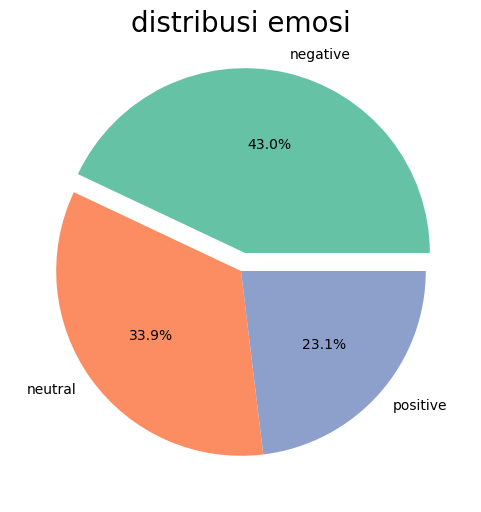

In [69]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['label'].value_counts()]
labels = list(df['label'].value_counts().index)
explode = (0.1, 0, 0)  # Offset the first segment
# Gunakan palet warna Seaborn
colors = sns.color_palette('Set2')
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, textprops={'fontsize': 10})
ax.set_title('distribusi emosi', fontsize = 20)
plt.show()

<a id='2.1'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">2.1 WordCloud 📊</p>

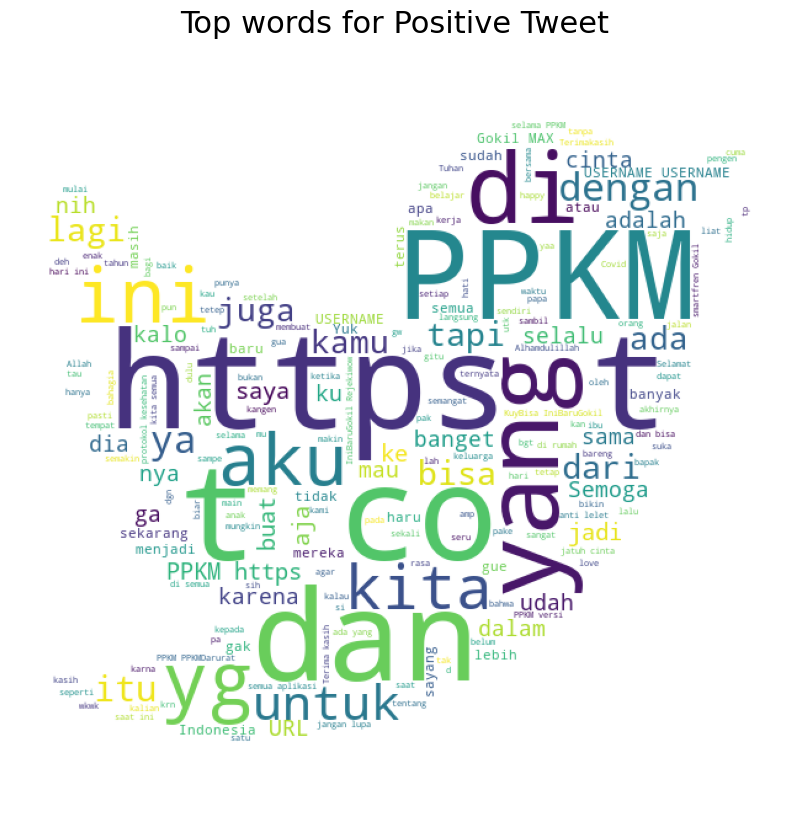

In [70]:
import requests
from PIL import Image
from io import BytesIO

url = "https://image.freepik.com/free-icon/twitter-logo_318-40459.jpg"  # replace with your image URL
response = requests.get(url)
twitter_mask = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'positive', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

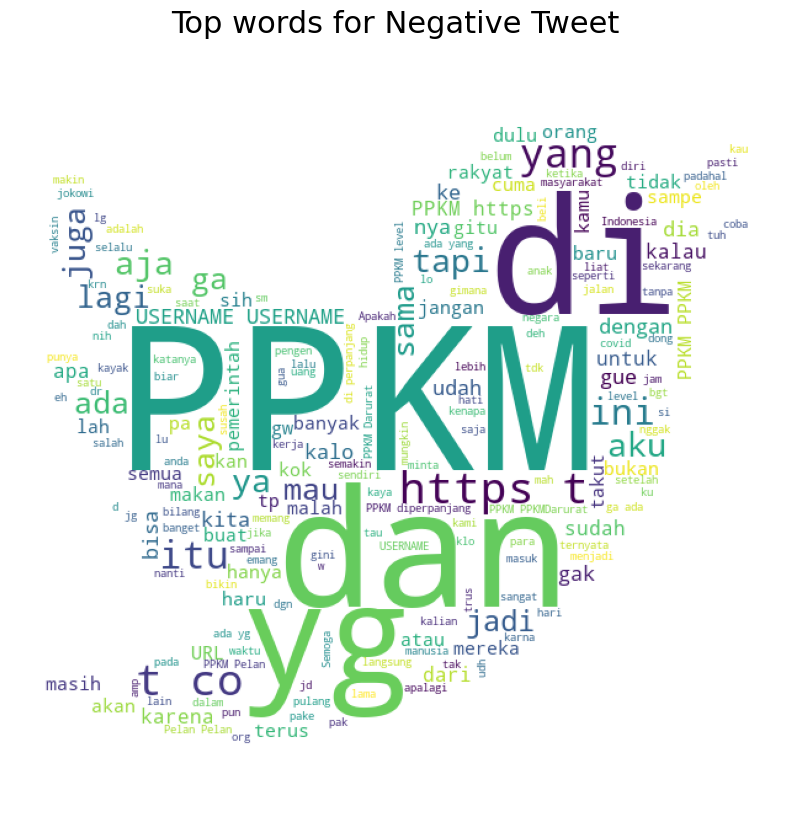

In [71]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'negative', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

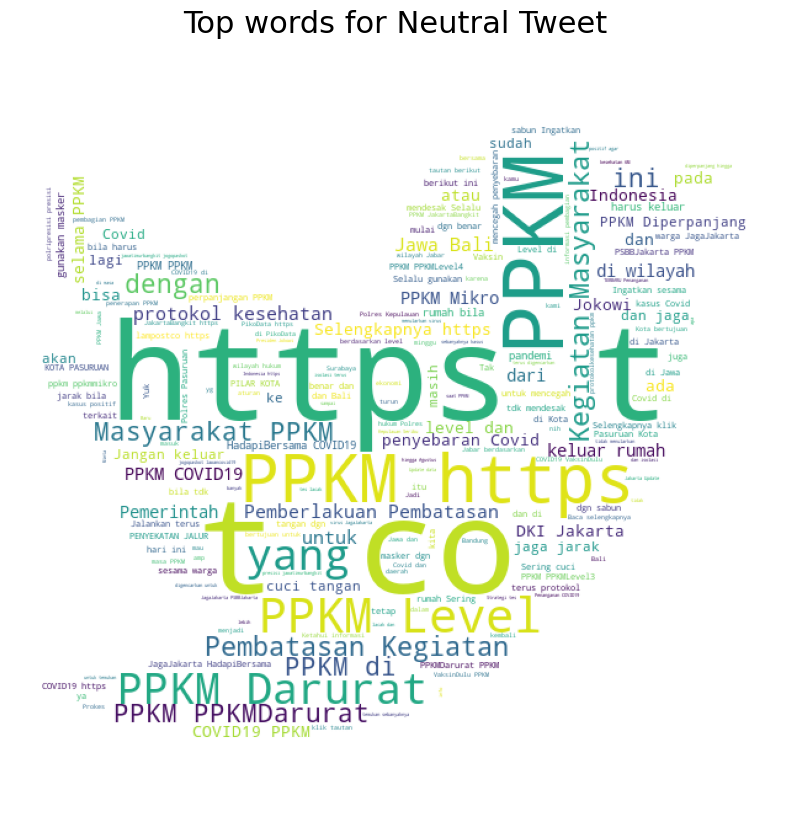

In [72]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'neutral', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Neutral Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<a id='3'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">3. Preprocessing 📊</p>

In [73]:
stopword_bahasa = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/stopwordbahasa.csv', encoding='latin-1')
stopword_bahasa = stopword_bahasa.rename(columns={0: 'stop'})
stopword_bahasa.head()

,ada
0,adalah
1,adanya
2,adapun
3,agak
4,agaknya


In [74]:
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_alay.csv', header=None, encoding='latin-1')
kamus_alay = kamus_alay.rename(columns={0: 'original',
                                     1: 'replacement'})
kamus_alay_map = dict(zip(kamus_alay['original'], kamus_alay['replacement']))
kamus_alay.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [75]:
kamus_singkatan = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_singkatan.csv', sep=';', encoding='latin-1')
kamus_singkatan.columns = ['Column1', 'Column2']
kamus_singkatan = kamus_singkatan.rename(columns={'Column1': 'original', 'Column2': 'replacement'})
kamus_singkatan_map = dict(zip(kamus_singkatan['original'], kamus_singkatan['replacement']))
kamus_singkatan.head()

,original,replacement
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja


<a id='3.1'></a>
## <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">3.1 Cleaning 📊</p>

In [76]:
# List of words to remove
remove_words = ['ppkm', 'covid']

def remove_unnecessary_char(text):
    text = text.lower()
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    for word in remove_words:
        text = re.sub(word, '', text)  # remove word
    return text
df["cleaning"] = df.Tweet.apply(lambda text: remove_unnecessary_char(text))
df.head(3)

,Tweet,label,cleaning
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative,soal jln jatibaru polisi tdk bs ge ak gubernur...
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative,sesama cewe lho kayaknya harusnya bisa lebih r...
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive,kepingin gudeg mbarek bu hj amad foto dari goo...


<a id='3.2'></a>
## <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">3.2 Normalization 📊</p>

In [77]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    return ' '.join(do)
# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text
df['preprocessing'] = df['cleaning'].apply(preprocess)
df

,Tweet,label,cleaning,preprocessing
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative,soal jln jatibaru polisi tdk bs ge ak gubernur...,jalan jatibaru polisi ge gubernur emangny poli...
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative,sesama cewe lho kayaknya harusnya bisa lebih r...,cewek kayak rasa sibuk jaga rasa sakit haid pa...
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive,kepingin gudeg mbarek bu hj amad foto dari goo...,gudeg mbarek bu hj foto google sengaja biar te...
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",negative,jln jatibaru bagian dari wilayah tn abang peng...,jalan jatibaru wilayah tn abang atur wilayah w...
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",positive,sharing pengalaman aja kemarin jam 18 00 batal...,sharing alam kemarin jam 18 00 batalin tiket s...
...,...,...,...,...
15645,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,neutral,satpol pp sidak pelaksanaan sekolah tatap muka...,satu polisi pp inspeksi dadak laksana sekolah ...
15646,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,neutral,perlakuan petugas darurat ke paspamres dapat ...,laku tugas darurat paspamres sorot anggota dew...
15647,Jadi di perpanjang atau stop sampai hari ini s...,neutral,jadi di perpanjang atau stop sampai hari ini s...,panjang stop 25 07 2021 tunggu papaeko wfh
15648,Polres Kepulauan Seribu Terus bagikan masker d...,neutral,polres kepulauan seribu terus bagikan masker d...,polisi resor pulau ribu bagi masker rangka ceg...


<a id='4'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">4. Ekstraksi Feature 📊</p>

In [ ]:
# Label encoding
le = LabelEncoder()
le.fit(df['label'])
target_encoded = le.transform(df['label'])

# One-hot encoding
target_onehot = to_categorical(target_encoded, num_classes=3)  # 3 karena ada 3 kelas: negative, neutral, positive


In [79]:
texts = df['preprocessing']

In [80]:
# Tokenizer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
print(f'Vocab length: {vocab_length}')

Vocab length: 26629


In [81]:
# Fungsi embed untuk mengubah teks menjadi sequences
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

# Pastikan semua item di texts adalah string
assert all(isinstance(text, str) for text in texts), "Semua item di texts harus berupa string."

# Mencari kalimat terpanjang
longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

# Padding sequences
train_padded_sentences = pad_sequences(
    embed(texts),
    maxlen=length_long_sentence,
    padding='post'
)
print(train_padded_sentences)

[[   14  7278    36 ...     0     0     0]
 [  294   721   242 ...     0     0     0]
 [ 7280 10847   901 ...     0     0     0]
 ...
 [    6   964   428 ...     0     0     0]
 [   36   168   291 ...     0     0     0]
 [  144   234   463 ...     0     0     0]]


In [83]:
# Load GloVe embeddings
embeddings_dictionary = dict()
embedding_dim = 100

with open(r"C:\Users\rizky\Downloads\glove.6B.100d.txt", encoding='utf8') as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# Create embedding matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))

In [ ]:
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print(f'Embedding matrix shape: {embedding_matrix.shape}')

Embedding matrix shape: (29074, 100)


<a id='5'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">5. Tokenize n Padding 📊</p>

In [84]:
max_words = 5000

max_len=50

def tokenize_pad_sequences(text):
    """This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length"""
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['preprocessing'][0])
X, tokenizer = tokenize_pad_sequences(df['preprocessing'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 jalan jatibaru polisi ge gubernur emangny polisi pmbhasan politik atur wilayah hak gubernur tn abang turun turun pelik sabar nama nama uniform resource locator
After Tokenization & Padding 
 [  14   36 2612  239   36  485   51   87  761  239  939   73   73  249
    4    4   29   30   31    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [85]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

<a id='6'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">6. Modelling 🪄</p>

In [87]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target_onehot,
    test_size=0.25,
    random_state=42
)
# Periksa ukuran data
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}')

Training data shape: (11737, 51), Training labels shape: (11737, 3)
Test data shape: (3913, 51), Test labels shape: (3913, 3)


In [88]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

# Model architecture
def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=train_padded_sentences.shape[1],  # Panjang maksimum dari sequences
        trainable=False  # Gunakan embedding GloVe yang sudah ada
    ))

    model.add(Bidirectional(LSTM(
        units=128,  # Jumlah unit LSTM
        return_sequences=True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 karena ada 3 kelas: negative, neutral, positive

    return model

In [89]:
# Load GloVe embeddings
embeddings_dictionary = dict()
embedding_dim = 100

with open(r"C:\Users\rizky\Downloads\glove.6B.100d.txt", encoding='utf8') as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

In [90]:
# Create embedding matrix
vocab_size = len(word_tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [91]:
# Compile and train the model
model = glove_lstm()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

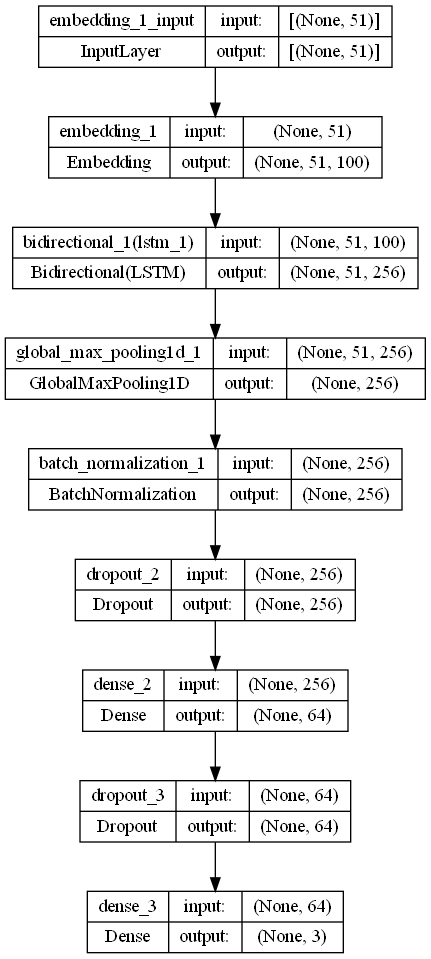

In [92]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [93]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/10
367/367 [==============================] - 87s 227ms/step - loss: 1.1871 - accuracy: 0.5242 - val_loss: 0.8606 - val_accuracy: 0.6292
Epoch 2/10
367/367 [==============================] - 87s 238ms/step - loss: 0.8425 - accuracy: 0.6204 - val_loss: 0.7312 - val_accuracy: 0.6818
Epoch 3/10
367/367 [==============================] - 2012s 5s/step - loss: 0.7778 - accuracy: 0.6514 - val_loss: 0.7000 - val_accuracy: 0.6946
Epoch 4/10
367/367 [==============================] - 94s 256ms/step - loss: 0.7419 - accuracy: 0.6637 - val_loss: 0.6995 - val_accuracy: 0.6885
Epoch 5/10
367/367 [==============================] - 95s 258ms/step - loss: 0.7253 - accuracy: 0.6816 - val_loss: 0.7033 - val_accuracy: 0.6839
Epoch 6/10
367/367 [==============================] - 93s 253ms/step - loss: 0.6994 - accuracy: 0.6948 - val_loss: 0.6825 - val_accuracy: 0.7084
Epoch 7/10
367/367 [==============================] - 79s 216ms/step - loss: 0.6822 - accuracy: 0.7010 - val_loss: 0.6951 - val_acc

In [94]:
# Prediksi
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

123/123 [==============================] - 7s 50ms/step


<a id='7'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">6. Metric Evaluate 🪄</p>

In [95]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.65      0.90      0.75      1697
     neutral       0.82      0.72      0.77      1280
    positive       0.79      0.37      0.50       936

    accuracy                           0.71      3913
   macro avg       0.75      0.66      0.67      3913
weighted avg       0.74      0.71      0.70      3913



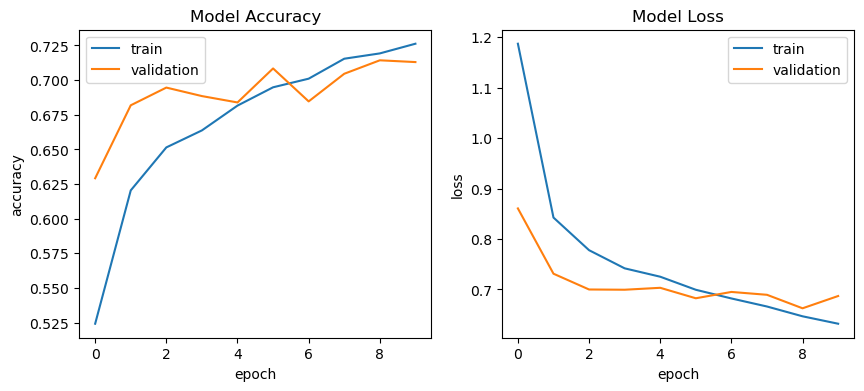

In [96]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

123/123 [==============================] - 6s 51ms/step


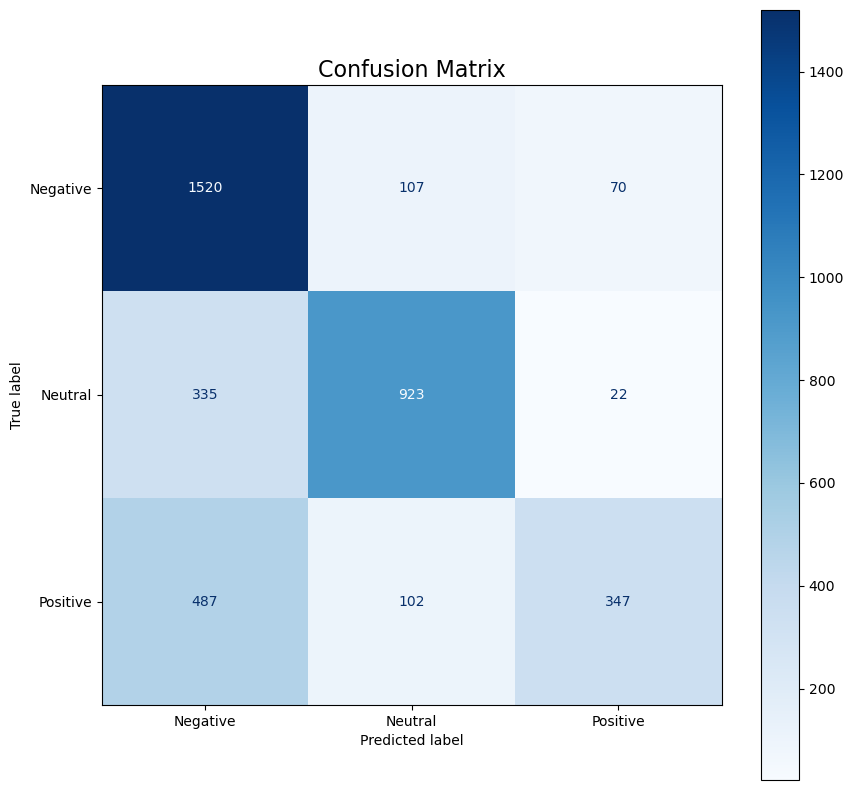

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay

# Use model to do the prediction
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

# Define the labels
labels = ['Negative', 'Neutral', 'Positive']

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix using the plot method of ConfusionMatrixDisplay
plt.figure(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [99]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))


Accuracy  : 0.7130


NameError: name 'precision' is not defined

In [100]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


<a id='7'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white;">7. Testing Modelling 🪄</p>

In [101]:
from keras.models import load_model

# Load model
model = load_model(r'C:\Users\rizky\OneDrive\Dokumen\GitHub\Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X\best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=51

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [102]:
predict_class(['KIPK sesuai Sasaran dan tepat waktu'])

1/1 [==============================] - 0s 415ms/step
The predicted sentiment is Negative


In [103]:
predict_class(['KIPK tidak tepat sasaran dan merugikan banyak mahasiswa'])

1/1 [==============================] - 0s 58ms/step
The predicted sentiment is Negative


In [104]:
predict_class(['prabowo ganteng'])

1/1 [==============================] - 0s 52ms/step
The predicted sentiment is Negative
